In [1]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 49kB/s 


In [2]:
! pip install keras

In [3]:
! pip install pandas

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [6]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score
import os
import cv2

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
X = []
y = []
IMG_SIZE = 224
DIR = "/content/drive/My Drive/Colab Notebooks/Car Brands/Train/"
folders1 = os.listdir(DIR)
folders1

['Hyundai', 'Honda']

In [9]:

for i, file in enumerate(folders1):
    filename = os.path.join(DIR, file)
    print("Folder {} started".format(file))
    try:
        for img in os.listdir(filename):
            path = os.path.join(filename, img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            y.append(i)
    except:
        print("File {} not read".format(path))
        
    print("Folder {} done".format(file))
    print("The folder {} is labeled as {}".format(file, i))



Folder Hyundai started
Folder Hyundai done
The folder Hyundai is labeled as 0
Folder Honda started
Folder Honda done
The folder Honda is labeled as 1


In [11]:
len(X)

2004

[1151, 567, 753, 494, 1862, 1909, 116, 407, 1325, 1657]


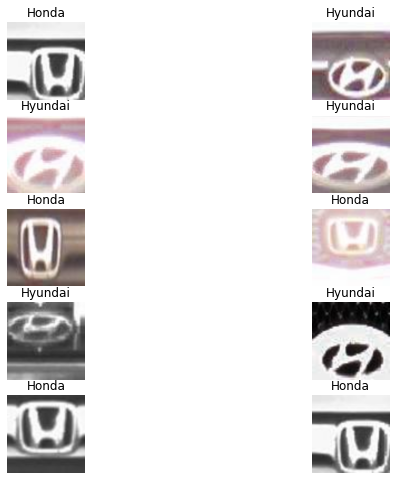

In [10]:
import random
from random import sample
plt.figure(figsize=(10,10))
random_indexes = sample(range(1, 2000), 10)
print(random_indexes)
for i, img_index in enumerate(random_indexes):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(6,2, i + 1)
  sp.set_title(folders1[y[img_index]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X[img_index])


In [12]:
X = np.array(X)
y = np.array(y)

print("X shape is {}".format(X.shape))
print("y shape is {}".format(y.shape))

X shape is (2004, 224, 224, 3)
y shape is (2004,)


In [13]:
from tensorflow.keras.utils import to_categorical

print("Before the categorical the shape of y is {}".format(y.shape))
y = to_categorical(y)
print("After the categorical the shape of y is {}".format(y.shape))

Before the categorical the shape of y is (2004,)
After the categorical the shape of y is (2004, 2)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("There are {} training examples".format(X_train.shape[0]))
print("There are {} test examples".format(X_test.shape[0]))

There are 1402 training examples
There are 602 test examples


In [15]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


validation_datagen = ImageDataGenerator(
      rescale = 1./255)

In [16]:
training_set=training_datagen.flow(X_train,y_train)
test_set=validation_datagen.flow(X_test,y_test)

In [17]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3",
# Here we will be using imagenet weights\n"
IMAGE_SIZE=[224,224]
vgg= VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [18]:
# don't train existing weights\n",
for layer in vgg.layers:
    layer.trainable = False

In [19]:
folders = glob('/content/drive/My Drive/Colab Notebooks/Car Brands/Train/*')
len(folders)

2

In [20]:
x = Flatten()(vgg.output)

In [21]:

prediction=Dense(len(folders), activation='softmax')(x)

In [22]:
model = Model(inputs=vgg.input, outputs=prediction)

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [24]:

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [25]:
batch_size=32
r= model.fit_generator(training_set,epochs = 20, validation_data = test_set,verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
43/43 [==============================] - 19s 451ms/step - loss: 0.5464 - accuracy: 0.7745 - val_loss: 0.1414 - val_accuracy: 0.9402
Epoch 2/20
43/43 [==============================] - 18s 416ms/step - loss: 0.2091 - accuracy: 0.9190 - val_loss: 0.1066 - val_accuracy: 0.9568
Epoch 3/20
43/43 [==============================] - 18s 413ms/step - loss: 0.1660 - accuracy: 0.9387 - val_loss: 0.0959 - val_accuracy: 0.9502
Epoch 4/20
43/43 [==============================] - 18s 415ms/step - loss: 0.1616 - accuracy: 0.9336 - val_loss: 0.1018 - val_accuracy: 0.9485
Epoch 5/20
43/43 [==============================] - 18s 424ms/step - loss: 0.1724 - accuracy: 0.9263 - val_loss: 0.0988 - val_accuracy: 0.9535
Epoch 6/20
43/43 [==============================] - 18s 418ms/step - loss: 0.1766 - accuracy: 0.9204 - val_loss: 0.0535 - val_accuracy: 0.9834
Epoch 7/20
43/43 [==============================] - 18s 413ms/step

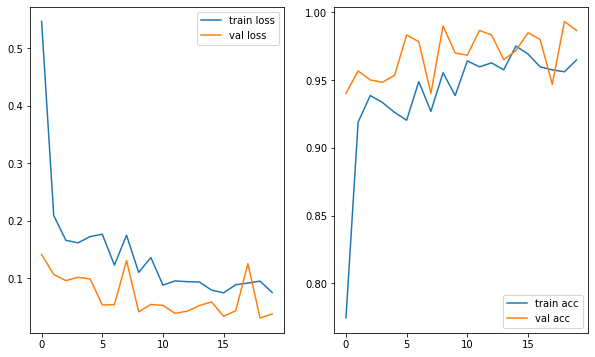

In [26]:
# plot the loss
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc')

In [27]:
k=r.history['val_accuracy']
print('The Validation Accuracy of VGG19 Model: ', np.array(k[-1]))

The Validation Accuracy of VGG19 Model:  0.9867109656333923


In [28]:
# save it as a h5 file

from tensorflow.keras.models import load_model
model.save('CarLogo_model_vgg19.h5')

In [29]:
y_pred = model.predict(X_test)
y_pred_digits = np.argmax(y_pred, axis=1)
y_pred_digits

y_pred_labels = np.unique(y_pred_digits, return_counts=True)
y_pred_labels


(array([0, 1]), array([243, 359]))

In [30]:
real_labels= np.argmax(y_test, axis=1)
real_labels
real_labels1 = np.unique(real_labels, return_counts=True)
real_labels1

(array([0, 1]), array([303, 299]))

In [31]:
from sklearn.metrics import confusion_matrix
c_m = confusion_matrix(real_labels, y_pred_digits)
c_m

array([[240,  63],
       [  3, 296]])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


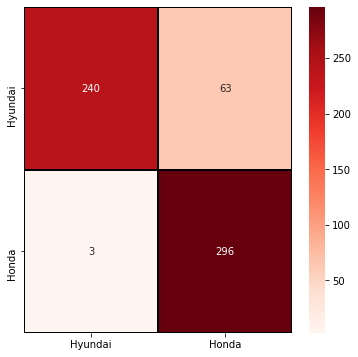

In [32]:
import seaborn as sns
plt.figure(figsize = (6,6))
sns.heatmap(c_m,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = folders1 , yticklabels = folders1)

In [33]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score
acc_score = accuracy_score(real_labels, y_pred_digits)
acc_score

0.8903654485049833

In [34]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(real_labels)):
    if(real_labels[i] == y_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==10):
        break
i=0
for i in range(len(real_labels)):
    if(real_labels[i] != y_pred_digits[i]):
        mis_class.append(i)


In [35]:
print(len(mis_class))

66


[7, 4, 0, 3, 9, 8, 1, 2, 6, 5]


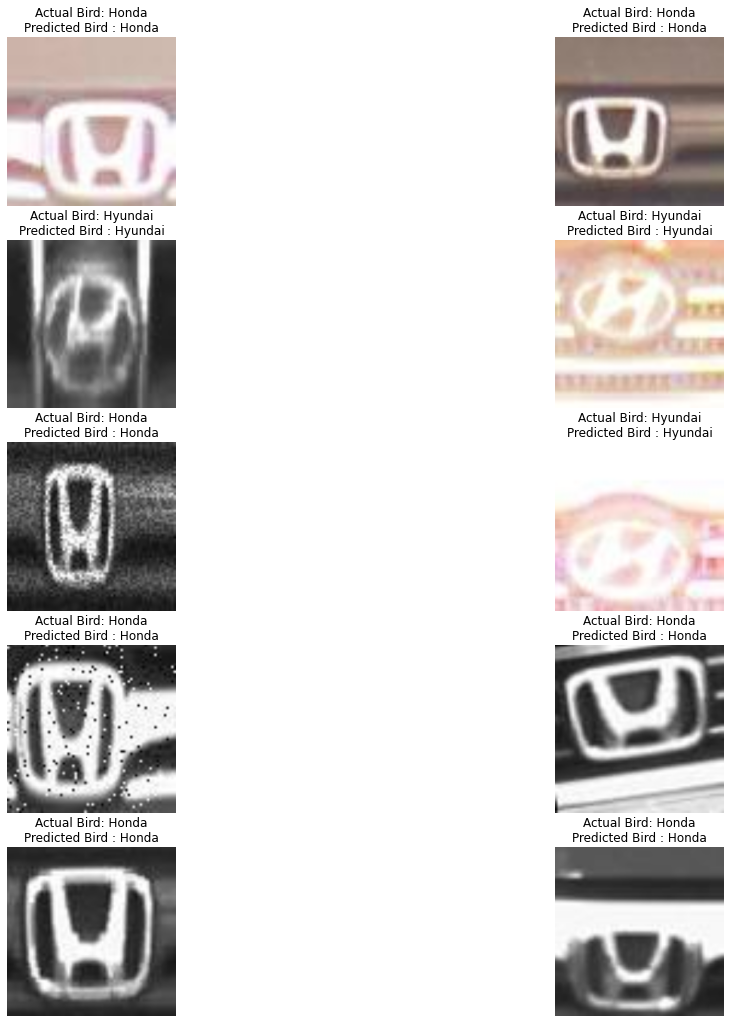

In [36]:
labels_names={0:'Hyundai', 
        1:'Honda',
        }
#fig.set_size_inches(8,8)
import random
from random import sample
plt.figure(figsize=(18,18))
random_indexes = sample(range(0, 10), 10)
print(random_indexes)
for i, img_index in enumerate(random_indexes):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 2, i + 1)
  sp.set_title('Actual Bird: '+ labels_names[real_labels[prop_class[img_index]]]+ '\n' + 'Predicted Bird : ' + labels_names[y_pred_digits[prop_class[img_index]]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X_test[prop_class[img_index]])

[0, 4, 3, 2, 5, 1, 7, 6, 8, 9]


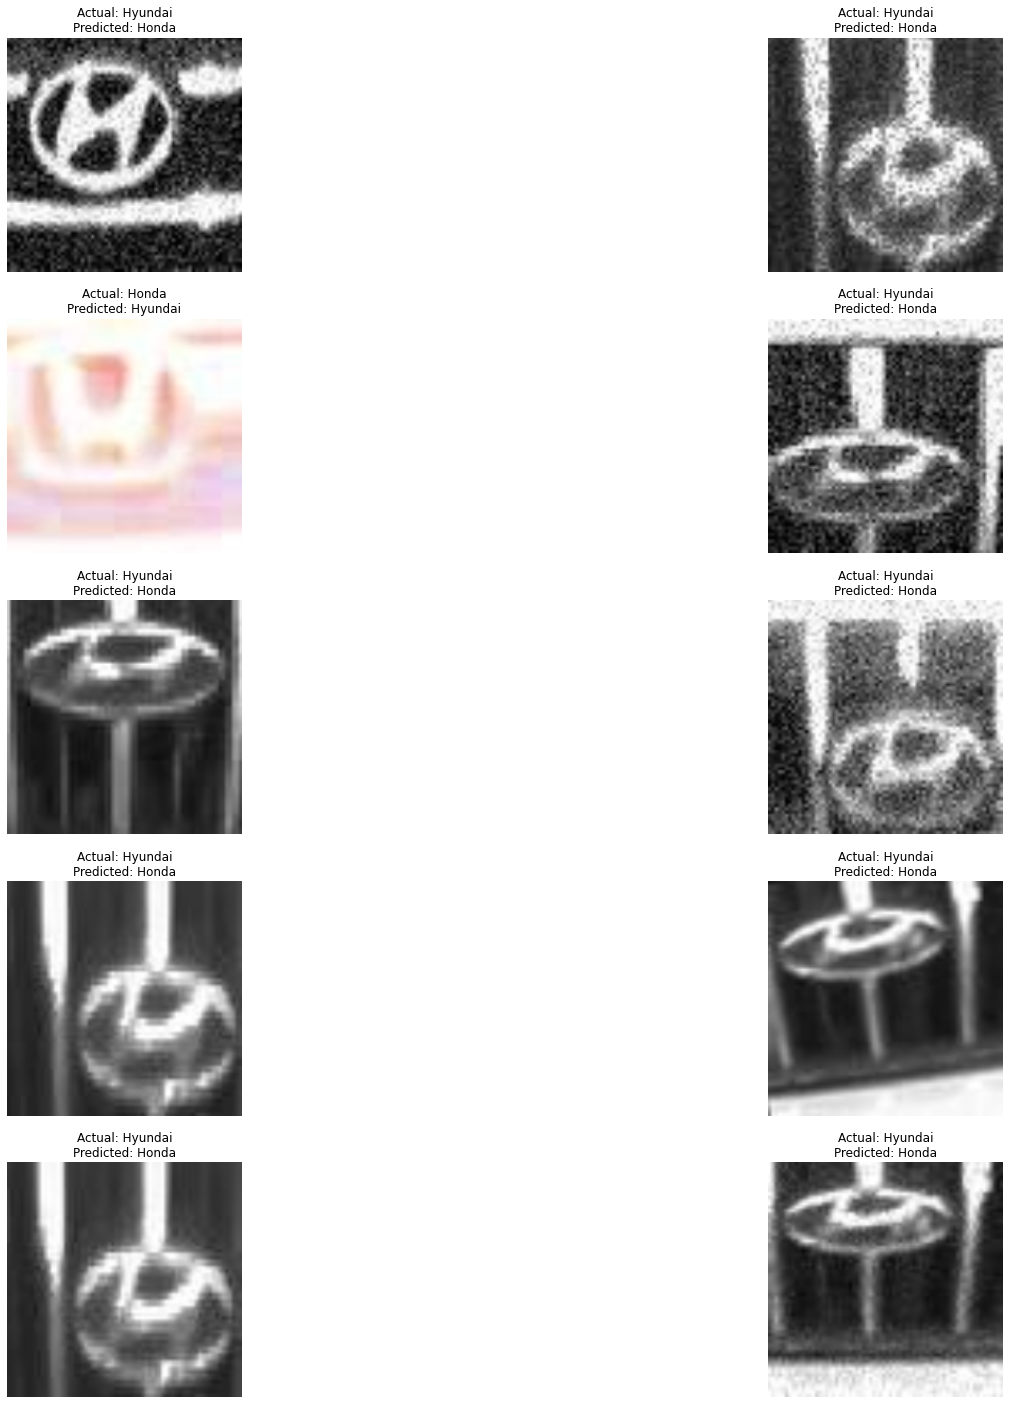

In [37]:
labels_names={0:'Hyundai', 
        1:'Honda',
        }
import random
from random import sample

random_indexes = sample(range(0, 10), 10)
print(random_indexes)
plt.figure(figsize=(25,25))
for i, img_index in enumerate(random_indexes):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 2, i + 1)
  sp.set_title('Actual: '+ labels_names[real_labels[mis_class[img_index]]]+ '\n' + 'Predicted: ' + labels_names[y_pred_digits[mis_class[img_index]]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X_test[mis_class[img_index]])

In [ ]:
# Evaluate The Model with Different Images

In [38]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [39]:
model=load_model('CarLogo_model_vgg19.h5')

In [53]:
img=image.load_img('/content/drive/My Drive/Colab Notebooks/Car Brands/Honda.jpg',target_size=(224,224))

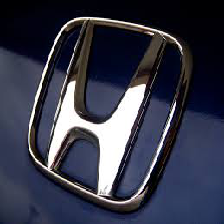

In [54]:
img


In [55]:
y=image.img_to_array(img)
y=np.expand_dims(y,axis=0)
imgy=preprocess_input(y)
imgy=imgy/255

In [56]:
preds= model.predict(imgy)
preds

array([[2.3154292e-09, 1.0000000e+00]], dtype=float32)

In [57]:
a=np.argmax(preds, axis=1)
a

array([1])

In [58]:
if (a==0):
    print("Hyundai")
else:
    print("Honda")


Honda
